# Word Embeddings

## Preparación de ambiente

### Carga de módulos

In [1]:
import re  
import spacy
import numpy as np
import unicodedata
import pandas as pd
from PIL import Image
import cufflinks as cf
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from collections import defaultdict
from wordcloud import ImageColorGenerator
from wordcloud import WordCloud, STOPWORDS
from gensim.models.phrases import Phrases, Phraser

cf.go_offline()

###  Funciones relvantes 

In [2]:
def clean_text(text, pattern="[^a-zA-Z0-9 ]"):
    cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, " ", cleaned_text.decode("utf-8"), flags=re.UNICODE)
    cleaned_text = u' '.join(cleaned_text.lower().split())
    return cleaned_text

In [3]:
def stemming(text, stop_words, stemmer):
    tokens = text.split(" ")
    tokens = [x for x in tokens if x not in stop_words]
    tokens = [stemmer.stem(x) for x in tokens]
    return " ".join(tokens)

In [4]:
def get_wordcloud(text, font_path='/home/oscar/Descargas/simpsonfont/Simpsonfont DEMO.otf', mask_path='/home/oscar/Descargas/simpsons_PNG27.png'):
    mask = np.array(Image.open(mask_path))
    mask_colors = ImageColorGenerator(mask)
    wc = WordCloud(stopwords=STOPWORDS, font_path=font_path, 
                   background_color="white", max_words=2000,
                   max_font_size=100, random_state=42,
                   width=mask.shape[1], height=mask.shape[0], color_func=mask_colors)
    wc.generate(text)
    plt.figure(figsize=(50, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

## Data Wrangling

### Carga de datos

In [5]:
df = pd.read_csv('./simpsons_dataset.csv')
df.shape

(158314, 2)

In [6]:
df

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
...,...,...
158309,Miss Hoover,I'm back.
158310,Miss Hoover,"You see, class, my Lyme disease turned out to ..."
158311,Miss Hoover,Psy-cho-so-ma-tic.
158312,Ralph Wiggum,Does that mean you were crazy?


### EDA

In [7]:
df

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
...,...,...
158309,Miss Hoover,I'm back.
158310,Miss Hoover,"You see, class, my Lyme disease turned out to ..."
158311,Miss Hoover,Psy-cho-so-ma-tic.
158312,Ralph Wiggum,Does that mean you were crazy?


In [8]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [9]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [10]:
df

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
...,...,...
131848,Miss Hoover,I'm back.
131849,Miss Hoover,"You see, class, my Lyme disease turned out to ..."
131850,Miss Hoover,Psy-cho-so-ma-tic.
131851,Ralph Wiggum,Does that mean you were crazy?


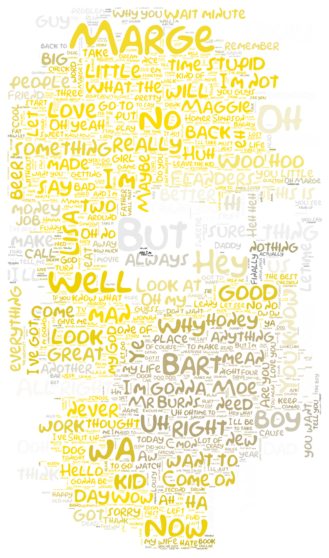

In [11]:
get_wordcloud(text = " ".join(df.loc[df["raw_character_text"]=="Homer Simpson", "spoken_words"]))

### Limpieza de texto

In [12]:
ls_sw = list(set(map(clean_text, stopwords.words('english'))))

In [13]:
ls_sw

['yours',
 'over',
 'but',
 'couldn t',
 'while',
 'no',
 'who',
 'it s',
 'why',
 'hadn t',
 'do',
 'both',
 'is',
 'doing',
 'then',
 'o',
 'she',
 'until',
 'them',
 'theirs',
 'same',
 'been',
 'aren',
 'she s',
 'himself',
 'its',
 'he',
 'you re',
 'an',
 'this',
 'isn',
 'not',
 'further',
 'aren t',
 'with',
 'any',
 'did',
 'below',
 'mightn',
 'above',
 'myself',
 'such',
 'didn t',
 'between',
 'herself',
 'his',
 'than',
 'wasn t',
 'how',
 'if',
 'of',
 'was',
 'so',
 'couldn',
 'don t',
 'there',
 's',
 'her',
 'shouldn t',
 'shan t',
 'being',
 'we',
 'whom',
 'once',
 'ma',
 'now',
 'should ve',
 'off',
 'other',
 'are',
 'you d',
 'those',
 'can',
 'him',
 'wouldn',
 'weren t',
 'because',
 'having',
 'it',
 'up',
 'd',
 'you ll',
 'hers',
 'hadn',
 'wouldn t',
 'shan',
 'at',
 're',
 'their',
 'itself',
 'have',
 'for',
 'weren',
 'a',
 'll',
 'your',
 'from',
 'about',
 'as',
 'they',
 't',
 'where',
 've',
 'needn t',
 'you',
 'ourselves',
 'through',
 'during',
 'a

In [14]:
df["spoken_words"] = df["spoken_words"].map(clean_text)

In [17]:
df["spoken_words"] = df["spoken_words"].map(lambda x: " ".join([x for x in x.split(" ") if x not in ls_sw]))

In [19]:
# df["spoken_words"] = df["spoken_words"].map(lambda x: stemming(x, ls_sw, snow_stemmer))

In [20]:
df = df.dropna().drop_duplicates()

In [21]:
df.shape

(121146, 2)

### Preparación de texto

In [22]:
sent = [row.split() for row in df['spoken_words']]

In [23]:
sent

[['actually',
  'little',
  'sometimes',
  'disease',
  'magazines',
  'news',
  'shows',
  'natural',
  'think'],
 ['mr', 'bergstrom'],
 ['know',
  'although',
  'sure',
  'like',
  'talk',
  'touch',
  'lesson',
  'plan',
  'teach'],
 ['life', 'worth', 'living'],
 ['polls',
  'open',
  'end',
  'recess',
  'case',
  'decided',
  'put',
  'thought',
  'final',
  'statements',
  'martin'],
 ['think', 'anything', 'left', 'say'],
 ['bart'],
 ['victory', 'party', 'slide'],
 ['mr', 'bergstrom', 'mr', 'bergstrom'],
 ['hey',
  'hey',
  'moved',
  'morning',
  'must',
  'new',
  'job',
  'took',
  'copernicus',
  'costume'],
 ['know', 'could', 'find'],
 ['think', 'taking', 'next', 'train', 'capital', 'city'],
 ['train', 'like', 'traditional', 'yet', 'environmentally', 'sound'],
 ['yes',
  'backbone',
  'country',
  'since',
  'leland',
  'stanford',
  'drove',
  'golden',
  'spike',
  'promontory',
  'point'],
 ['see', 'touched'],
 ['hey', 'thanks', 'vote', 'man'],
 ['vote', 'voting', 'geeks'

In [24]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [25]:
bigram = Phraser(phrases)

In [26]:
sentences = bigram[sent]

In [28]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

39079

In [30]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'well', 'like', 'get', 'one', 'know', 'hey', 'right', 'got', 'homer']

## Modelado

### Detección de cores

In [31]:
cores = multiprocessing.cpu_count()

In [32]:
cores

8

### Word2Vec

In [33]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

### Construcción de vocabulario

In [34]:
w2v_model.build_vocab(sentences, progress_per=10000)

### Entrenamiento

In [35]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(7986707, 19863900)

In [36]:
w2v_model.init_sims(replace=True)

## Resultados

#### Similitudes

In [37]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.7075713276863098),
 ('busted', 0.6772562265396118),
 ('jessica', 0.671856164932251),
 ('listen', 0.6576111316680908),
 ('depressed', 0.6462967395782471),
 ('cab', 0.644760012626648),
 ('sitter', 0.6446585059165955),
 ('abe', 0.6437950134277344),
 ('shhh', 0.6422643065452576),
 ('becky', 0.6416086554527283)]

In [40]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('robert', 0.7422498464584351),
 ('selected', 0.7371676564216614),
 ('hereby', 0.7306289672851562),
 ('recent', 0.7220768928527832),
 ('charles', 0.7156915664672852),
 ('montgomery_burns', 0.7000507712364197),
 ('governor', 0.6961687803268433),
 ('pleased', 0.6943521499633789),
 ('council', 0.6925399303436279),
 ('hutz', 0.6898047924041748)]

In [41]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.7075713276863098),
 ('forgetting', 0.6636637449264526),
 ('homie', 0.6611853837966919),
 ('shift', 0.6514629125595093),
 ('jessica', 0.6497033834457397),
 ('becky', 0.6478356122970581),
 ('ned', 0.6462012529373169),
 ('sitter', 0.6392423510551453),
 ('kidney', 0.6386812925338745),
 ('eliza', 0.6356363296508789)]

In [42]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8243449926376343),
 ('jessica', 0.7171573042869568),
 ('creepy', 0.6949740648269653),
 ('mom_dad', 0.6919565796852112),
 ('dr_hibbert', 0.6770743131637573),
 ('noooo', 0.6736422777175903),
 ('grades', 0.6705820560455322),
 ('jealous', 0.6703586578369141),
 ('maggie', 0.6674153208732605),
 ('cemetery', 0.6658341884613037)]

In [43]:
w2v_model.wv.most_similar(positive=["simpson"])

[('abraham', 0.7963721752166748),
 ('j', 0.7300921082496643),
 ('eliza', 0.7020590305328369),
 ('abe', 0.6962214708328247),
 ('waylon', 0.6905412077903748),
 ('hutz', 0.6603584885597229),
 ('kennedy', 0.6571176052093506),
 ('expecting', 0.6216729879379272),
 ('howard', 0.6214077472686768),
 ('shift', 0.617685079574585)]

In [44]:
w2v_model.wv.similarity("moe", 'tavern')

0.8238418

In [45]:
w2v_model.wv.similarity('maggie', 'baby')

0.6783215

#### Representación vectorial

In [47]:
w2v_model.wv["homer"]

array([ 0.05358572,  0.0569724 , -0.07261288, -0.03188736,  0.0391272 ,
        0.04529379,  0.00148326, -0.01708254, -0.01240468, -0.00052544,
       -0.02458647,  0.0304338 ,  0.04107488,  0.00381572,  0.00465794,
        0.02604654,  0.02861208,  0.09458422, -0.02389416,  0.02638941,
        0.01631491,  0.13049468, -0.00202667,  0.01154015,  0.06741209,
        0.02607126,  0.02712551, -0.01146457, -0.04093083,  0.04818253,
       -0.05232872, -0.09709071, -0.07635999,  0.01089336,  0.03275976,
        0.01196462, -0.0551759 , -0.04070996, -0.0562973 ,  0.07004678,
       -0.05437737,  0.00569092,  0.05040711,  0.08650529,  0.04909884,
        0.06989142, -0.02832508, -0.03851192, -0.00542373, -0.0077282 ,
        0.01631597,  0.0325982 ,  0.0925884 , -0.07367355, -0.0064494 ,
       -0.14026345,  0.02118315, -0.06111956, -0.03850544, -0.0901693 ,
       -0.04779132, -0.03897162, -0.03399386,  0.09772633, -0.0641221 ,
       -0.05081684, -0.07256555, -0.0267514 , -0.07941161, -0.00

In [46]:
w2v_model.wv.__getitem__("homer")

array([ 0.05358572,  0.0569724 , -0.07261288, -0.03188736,  0.0391272 ,
        0.04529379,  0.00148326, -0.01708254, -0.01240468, -0.00052544,
       -0.02458647,  0.0304338 ,  0.04107488,  0.00381572,  0.00465794,
        0.02604654,  0.02861208,  0.09458422, -0.02389416,  0.02638941,
        0.01631491,  0.13049468, -0.00202667,  0.01154015,  0.06741209,
        0.02607126,  0.02712551, -0.01146457, -0.04093083,  0.04818253,
       -0.05232872, -0.09709071, -0.07635999,  0.01089336,  0.03275976,
        0.01196462, -0.0551759 , -0.04070996, -0.0562973 ,  0.07004678,
       -0.05437737,  0.00569092,  0.05040711,  0.08650529,  0.04909884,
        0.06989142, -0.02832508, -0.03851192, -0.00542373, -0.0077282 ,
        0.01631597,  0.0325982 ,  0.0925884 , -0.07367355, -0.0064494 ,
       -0.14026345,  0.02118315, -0.06111956, -0.03850544, -0.0901693 ,
       -0.04779132, -0.03897162, -0.03399386,  0.09772633, -0.0641221 ,
       -0.05081684, -0.07256555, -0.0267514 , -0.07941161, -0.00

In [48]:
len(w2v_model.wv.__getitem__("homer"))

300

In [49]:
df["raw_character_text"].value_counts().head(20)

Homer Simpson              24070
Marge Simpson              11593
Bart Simpson               11219
Lisa Simpson                9436
C. Montgomery Burns         2858
Moe Szyslak                 2683
Seymour Skinner             2274
Ned Flanders                1965
Chief Wiggum                1737
Grampa Simpson              1697
Milhouse Van Houten         1621
Krusty the Clown            1620
Lenny Leonard               1091
Nelson Muntz                1031
Apu Nahasapeemapetilon       949
Waylon Smithers              889
Kent Brockman                868
Carl Carlson                 801
Edna Krabappel-Flanders      681
Dr. Julius Hibbert           660
Name: raw_character_text, dtype: int64

In [50]:
ls_words = ['simpson', 'homer', 'marge', 'lisa', 'bart', 'burns', 'moe', 'skinner', 'flanders', "smithers", "abraham", "maggie"]

In [52]:
df_vect = pd.DataFrame(data=[w2v_model.wv.__getitem__(word) for word in ls_words], index=ls_words)

In [53]:
df_vect

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
simpson,0.003197,0.018019,0.006764,0.026099,0.110629,-0.037614,0.017534,-0.023823,-0.037303,0.076086,...,-0.034161,0.069665,0.054377,-0.077311,-0.056633,-0.046228,0.125784,0.019355,-0.003845,-0.092378
homer,0.053586,0.056972,-0.072613,-0.031887,0.039127,0.045294,0.001483,-0.017083,-0.012405,-0.000525,...,-0.078821,-0.051030,0.071459,-0.031308,0.028039,-0.006476,0.008143,0.077641,0.065066,-0.105551
marge,0.094169,0.068536,-0.064142,-0.008072,0.049311,-0.025424,-0.010464,0.000552,-0.031033,0.028231,...,-0.054635,-0.051482,0.050095,-0.027364,-0.043400,-0.077679,0.000965,0.078324,0.050407,-0.137213
lisa,-0.022584,0.019990,-0.122833,-0.114524,0.071045,0.054616,0.036539,-0.029514,-0.062601,-0.068555,...,-0.018841,-0.069891,0.003167,-0.033738,-0.027829,-0.045813,0.051316,-0.029164,0.074396,0.033156
bart,0.032436,-0.043846,-0.114184,-0.110441,0.112253,0.076655,0.037566,0.003559,-0.099717,-0.064797,...,-0.002041,-0.018803,0.032977,-0.010233,-0.046791,0.011784,0.017065,-0.010591,0.061320,-0.011380
burns,0.011912,-0.018751,0.106136,0.025210,0.078079,-0.011890,0.064898,-0.106168,0.004651,-0.009380,...,0.004267,-0.032650,0.037528,-0.091381,-0.052817,-0.009658,0.061775,-0.004355,0.078432,-0.004159
moe,-0.005350,-0.048901,-0.036761,0.028411,0.075170,0.004542,-0.093204,0.002832,0.043573,-0.042425,...,0.050920,0.023942,0.080320,-0.011025,0.009815,0.032163,0.045924,-0.011876,0.073757,-0.057289
skinner,0.008106,-0.054048,-0.024748,-0.013647,0.055377,0.045113,0.096763,0.039843,-0.128897,-0.008758,...,0.024075,0.020862,0.116346,-0.101982,-0.033407,0.093541,0.098716,0.002889,0.017599,-0.080998
flanders,-0.022233,0.028059,-0.031775,0.007856,0.023762,0.006684,-0.029091,0.052632,-0.074588,-0.037142,...,-0.048765,-0.049464,0.065161,-0.116112,-0.014454,-0.021654,-0.004035,0.025758,0.084539,-0.089651
smithers,0.060350,0.050959,-0.004073,0.033299,0.146451,0.029679,-0.053510,0.000910,-0.002654,0.025888,...,-0.103086,0.045760,0.032682,-0.129369,0.024316,-0.067891,0.055566,0.000566,0.046829,-0.068674


#### Visualización

In [54]:
mds = MDS(n_components=2, n_jobs=-1)

In [55]:
Xm = pd.DataFrame(data=mds.fit_transform(df_vect), columns=["d1", "d2"], index=df_vect.index)

In [56]:
Xm.reset_index().iplot(kind="scatter", x="d1", y="d2", mode="markers+text", text="index")

### Álgebra de embeddings

In [57]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

/home/oscar/VirtualEnvs/Python 3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'milhouse'

In [58]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [59]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

In [60]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.6903572082519531),
 ('chose', 0.589207112789154),
 ('maggie', 0.5779500603675842)]